<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/04_BoxJenkins_Method_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeSeries_ARIMA_BoxJenkins_Backtesting_R

# Box–Jenkins + ARIMA 백테스트(4가지) — R (Colab/R 커널)

이 노트북은 **Box–Jenkins 절차**(식별→추정→진단→예측)를 따르며, **ARIMA**로 아래 **4가지** 예측/평가 방식을 구현합니다.

1) **Full-sample (final fit)**: 전체 표본에 적합 후 미래 *h*일 예측 (평가용 X, 최종 적합용)  
2) **Fixed-origin (holdout)**: 80%로 한 번 적합 → 나머지 전 구간 **정적 파라미터**로 예측  
3) **Rolling-origin + Rolling window**: 원점 이동, **고정 길이 W** 창으로 매 스텝 재적합(1-step ahead)  
4) **Rolling-origin + Expanding window**: 원점 이동, **누적 창**으로 매 스텝 재적합(1-step ahead)

> 경고를 과도하게 내지 않도록 `auto.arima(max.d=1)` + `suppressWarnings()` 조합을 사용합니다.

In [13]:
# ---- 패키지 설치 (필요 시) ----
pkgs <- c("forecast", "tseries", "quantmod", "ggplot2", "dplyr", "tibble", "scales")
to_install <- setdiff(pkgs, rownames(installed.packages()))
if (length(to_install) > 0) {
  install.packages(to_install, repos = "https://cloud.r-project.org")
}

# ---- 로드 & 전역 옵션 ----
suppressMessages({
  library(forecast)
  library(tseries)
  library(quantmod)
  library(ggplot2)
  library(dplyr)
  library(tibble)
  library(scales)
})
options(warn = -1)       # 경고 억제(필요시)
options(stringsAsFactors = FALSE)

theme_set(theme_minimal(base_size = 12))

In [14]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res=150)

In [15]:
# -----------------------------
# 1) 데이터 수집 및 시계열 준비
# -----------------------------
symbol <- "TSLA"
from   <- "2022-01-01"
to     <- "2024-01-01"

cat("Downloading", symbol, "from Yahoo Finance ...\n")
xt <- tryCatch({
  suppressWarnings(getSymbols(symbol, src = "yahoo", from = from, to = to, auto.assign = FALSE))
}, error = function(e) NULL)

if (is.null(xt)) stop("데이터 다운로드 실패. 네트워크/티커를 확인하세요.")

df <- data.frame(Date = index(xt), coredata(xt))
names(df) <- c("Date", "Open","High","Low","Close","Volume","Adjusted")
df <- df %>% select(Date, Close) %>% filter(!is.na(Close))
df$Date <- as.Date(df$Date)

ts_data <- ts(df$Close, frequency = 1) # 비계절성 종가(레벨)
cat("Rows:", nrow(df), " | Date range:", as.character(min(df$Date)), "→", as.character(max(df$Date)), "\n")
head(df)

Rows: 501  | Date range: 2022-01-03 → 2023-12-29 


,Date,Close
,<date>,<dbl>
1,2022-01-03,399.9267
2,2022-01-04,383.1967
3,2022-01-05,362.7067
4,2022-01-06,354.9000
5,2022-01-07,342.3200
6,2022-01-10,352.7067


## Step 1. 식별 (Identification)

- (a) 정상성 여부 확인: **ADF 검정**  
- (b) 필요시 **차분(d)** 판단: `ndiffs(..., test="adf", max.d=2)`  
- (c) **ACF/PACF** 시각화

=== [원시계열 ADF test] ===

	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -2.6372, Lag order = 7, p-value = 0.3086
alternative hypothesis: stationary


=> 제안된 차분 차수 d = 1 (ADF 기준)



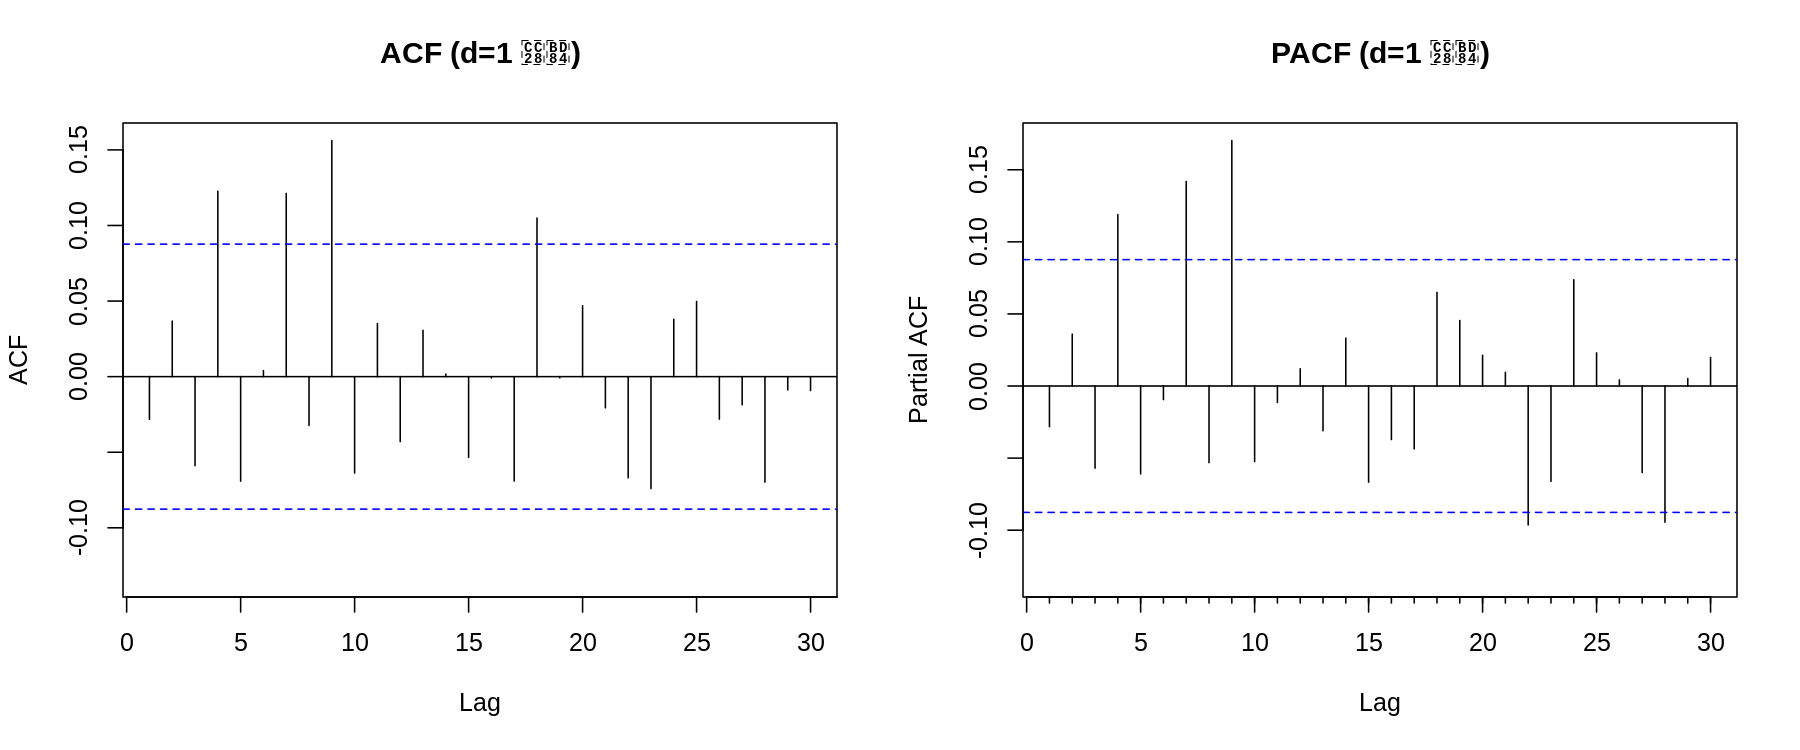

In [16]:
# (a) ADF(단위근) 검정
adf_res <- adf.test(ts_data)  # 기본 0차분
cat("=== [원시계열 ADF test] ===\n")
print(adf_res)

# (b) 차분 차수 제안 (ADF 기준, 최대 2차)
d_suggest <- suppressWarnings(ndiffs(ts_data, alpha = 0.05, test = "adf", max.d = 2))
cat(sprintf("\n=> 제안된 차분 차수 d = %d (ADF 기준)\n\n", d_suggest))

# (c) ACF/PACF 시각화
if (d_suggest > 0) {
  diff_series <- diff(ts_data, differences = d_suggest)
  par(mfrow = c(1,2))
  Acf(na.omit(diff_series), lag.max = 30, main = sprintf("ACF (d=%d 차분)", d_suggest))
  Pacf(na.omit(diff_series), lag.max = 30, main = sprintf("PACF (d=%d 차분)", d_suggest))
  par(mfrow = c(1,1))
} else {
  par(mfrow = c(1,2))
  Acf(ts_data, lag.max = 30, main = "ACF (원시계열)")
  Pacf(ts_data, lag.max = 30, main = "PACF (원시계열)")
  par(mfrow = c(1,1))
}

## Step 2. 추정 (Estimation)

`forecast::auto.arima`를 사용해 (p,d,q)를 **AICc 기준**으로 선택하고, 최대 차분은 `max.d = 1`로 제한하여 **과도한 경고**를 줄입니다.

## Step 3. 진단 (Diagnostic)

추정된 모델에 대해 잔차의 자기상관(ACF/PACF)과 Ljung–Box 검정을 간단히 확인합니다.

In [17]:
# -----------------------------
# 유틸 함수 (지표/안전 적합/1-step Forecast 등)
# -----------------------------
rmse <- function(a, f) sqrt(mean((a - f)^2, na.rm = TRUE))
mae  <- function(a, f) mean(abs(a - f), na.rm = TRUE)
r2   <- function(a, f) {
  sse <- sum((a - f)^2, na.rm = TRUE)
  sst <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  return(1 - sse/sst)
}

safe_auto_arima <- function(y, d_limit = 1, stepwise = TRUE, approx = FALSE) {
  # 경고 억제 + 실패 시 단순 평균 예측
  fit <- tryCatch({
    suppressWarnings(
      auto.arima(
        y, seasonal = FALSE, max.d = d_limit,
        stepwise = stepwise, approximation = approx,
        allowdrift = TRUE, allowmean = TRUE
      )
    )
  }, error = function(e) NULL)
  if (is.null(fit)) return(NULL) else return(fit)
}

diagnose_model <- function(fit) {
  if (is.null(fit)) { cat("진단 불가: 모델이 NULL\n"); return(invisible(NULL)) }
  res <- residuals(fit)
  par(mfrow = c(1,2))
  Acf(res, lag.max = 30, main = "Residual ACF")
  Pacf(res, lag.max = 30, main = "Residual PACF")
  par(mfrow = c(1,1))
  lb <- Box.test(res, lag = 20, type = "Ljung-Box")
  cat("Ljung–Box(20) p-value:", signif(lb$p.value, 4), "\n")
}

one_step_forecast <- function(y, d_limit = 1) {
  fit <- safe_auto_arima(y, d_limit = d_limit)
  if (is.null(fit)) {
    # fallback: 최근 5개 평균
    k <- min(5, length(y))
    return(mean(tail(y, k)))
  } else {
    return(as.numeric(forecast(fit, h = 1)$mean))
  }
}

In [18]:
# -----------------------------
# Train/Test 분할 (80 / 20)
# -----------------------------
n <- length(ts_data)
split_idx <- floor(n * 0.8)
y_train <- ts_data[1:split_idx]
y_test  <- ts_data[(split_idx + 1):n]

dates <- df$Date
dates_train <- dates[1:split_idx]
dates_test  <- dates[(split_idx + 1):n]

cat(sprintf("총 %d개 관측치 | train=%d, test=%d\n", n, length(y_train), length(y_test)))

총 501개 관측치 | train=400, test=101


=== auto.arima (train) 선택 모형 ===
Series: y 
ARIMA(0,1,0) 

sigma^2 = 91.76:  log likelihood = -1467.74
AIC=2937.48   AICc=2937.49   BIC=2941.47

=== 진단(학습모형) ===
Ljung–Box(20) p-value: 8.826e-05 


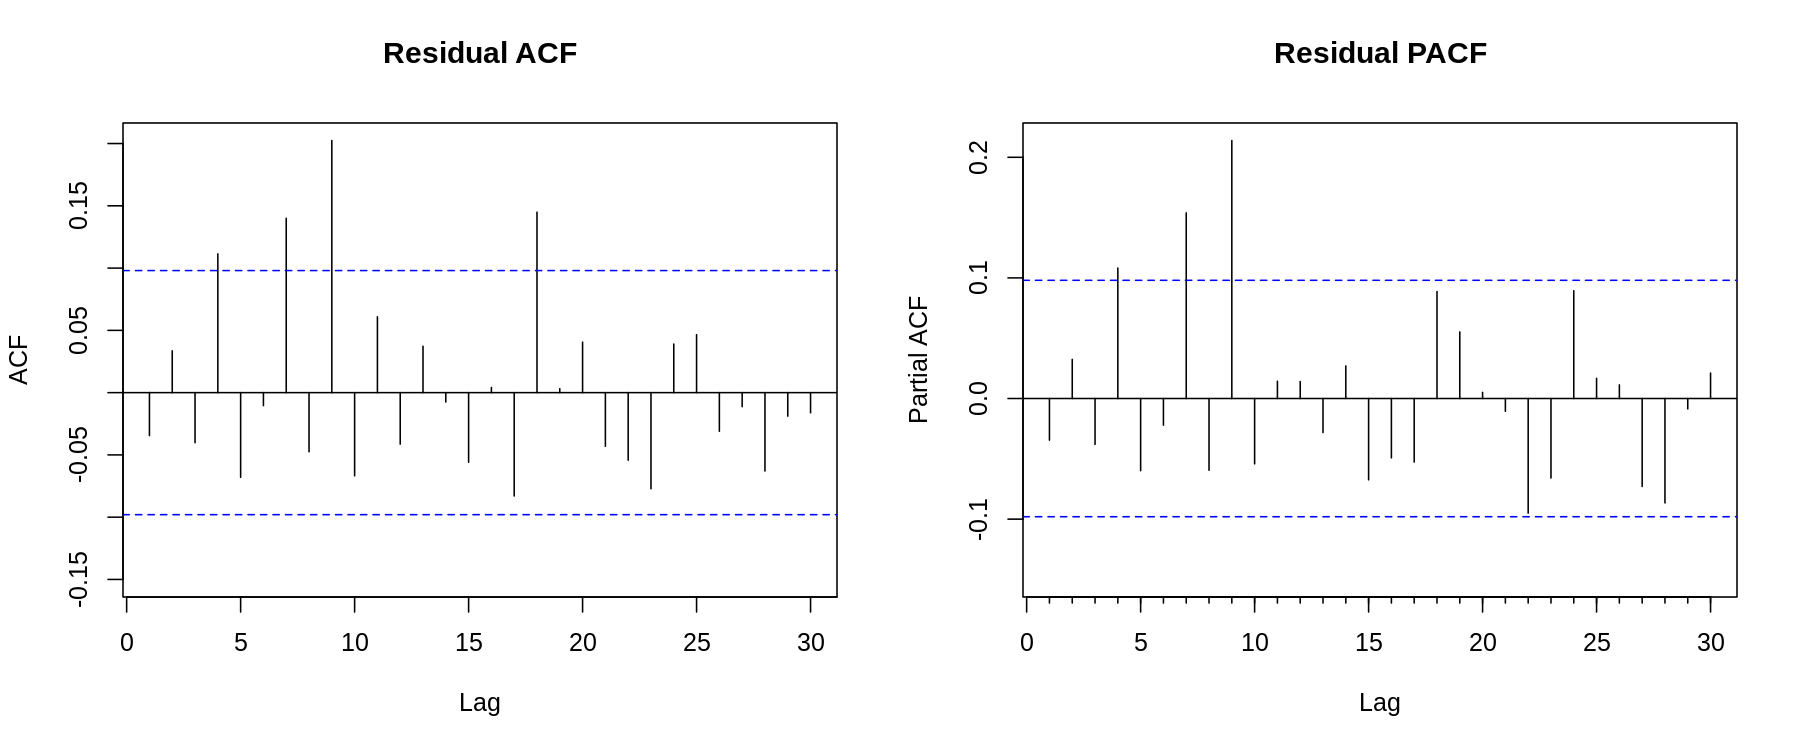

In [19]:
# -----------------------------
# (예시) 학습구간에서 한 번 추정/진단
# -----------------------------
fit_train <- safe_auto_arima(y_train, d_limit = 1)
cat("=== auto.arima (train) 선택 모형 ===\n")
print(fit_train)

cat("\n=== 진단(학습모형) ===\n")
diagnose_model(fit_train)

## 4) 예측 (Forecast) — 4가지 백테스트/운영 방식

### A. Full-sample (final fit)
전체 표본에 적합한 뒤, **미래 h일**을 예측합니다. (평가/백테스트 용도로는 권장되지 않습니다.)

Full-sample selected model:
Series: y 
ARIMA(0,1,0) 

sigma^2 = 83.44:  log likelihood = -1815.5
AIC=3633   AICc=3633.01   BIC=3637.22


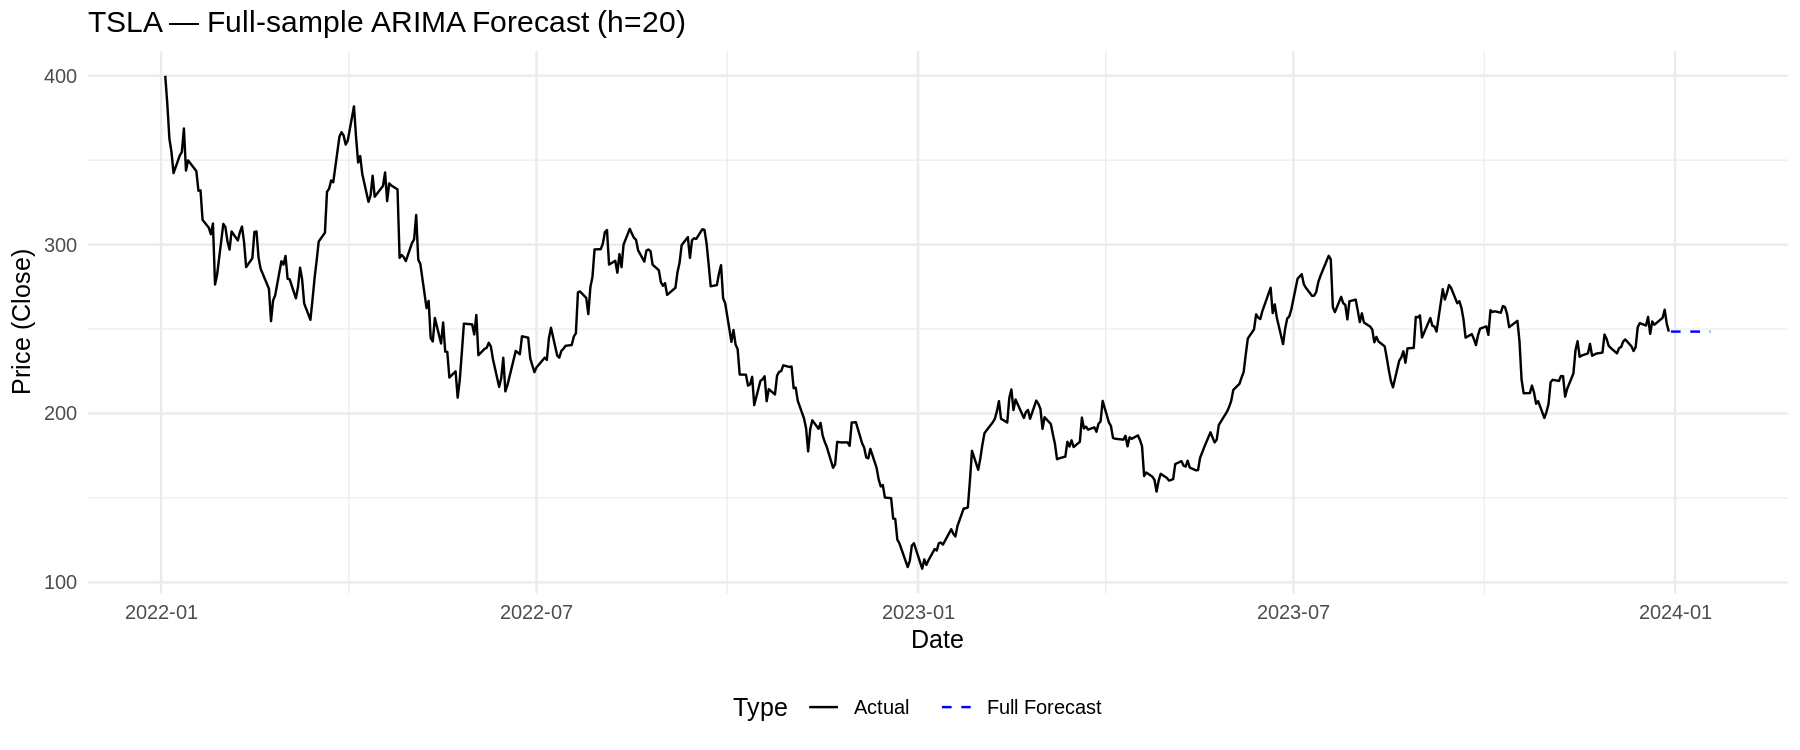

In [20]:
h <- 20  # 미래 예측 길이

fit_full <- safe_auto_arima(ts_data, d_limit = 1)
cat("Full-sample selected model:\n"); print(fit_full)

f_full <- forecast(fit_full, h = h)
future_dates <- seq(from = tail(df$Date, 1) + 1, by = "day", length.out = h)

# 시각화
plot_df <- bind_rows(
  tibble(Date = df$Date, Close = df$Close, Type = "Actual"),
  tibble(Date = future_dates, Close = as.numeric(f_full$mean), Type = "Full Forecast")
)

ggplot(plot_df, aes(Date, Close, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black", "Full Forecast" = "blue")) +
  scale_linetype_manual(values = c("Actual" = "solid", "Full Forecast" = "dashed")) +
  labs(title = sprintf("%s — Full-sample ARIMA Forecast (h=%d)", symbol, h),
       x = "Date", y = "Price (Close)") +
  theme(legend.position = "bottom")

### B. Fixed-origin (holdout, 정적 파라미터)
학습구간(80%)에 **한 번** 적합하고, 테스트 전구간을 **계수 고정** 상태로 예측합니다.

[Fixed-origin] RMSE=19.9963 | MAE=15.2640 | R^2=-0.3170


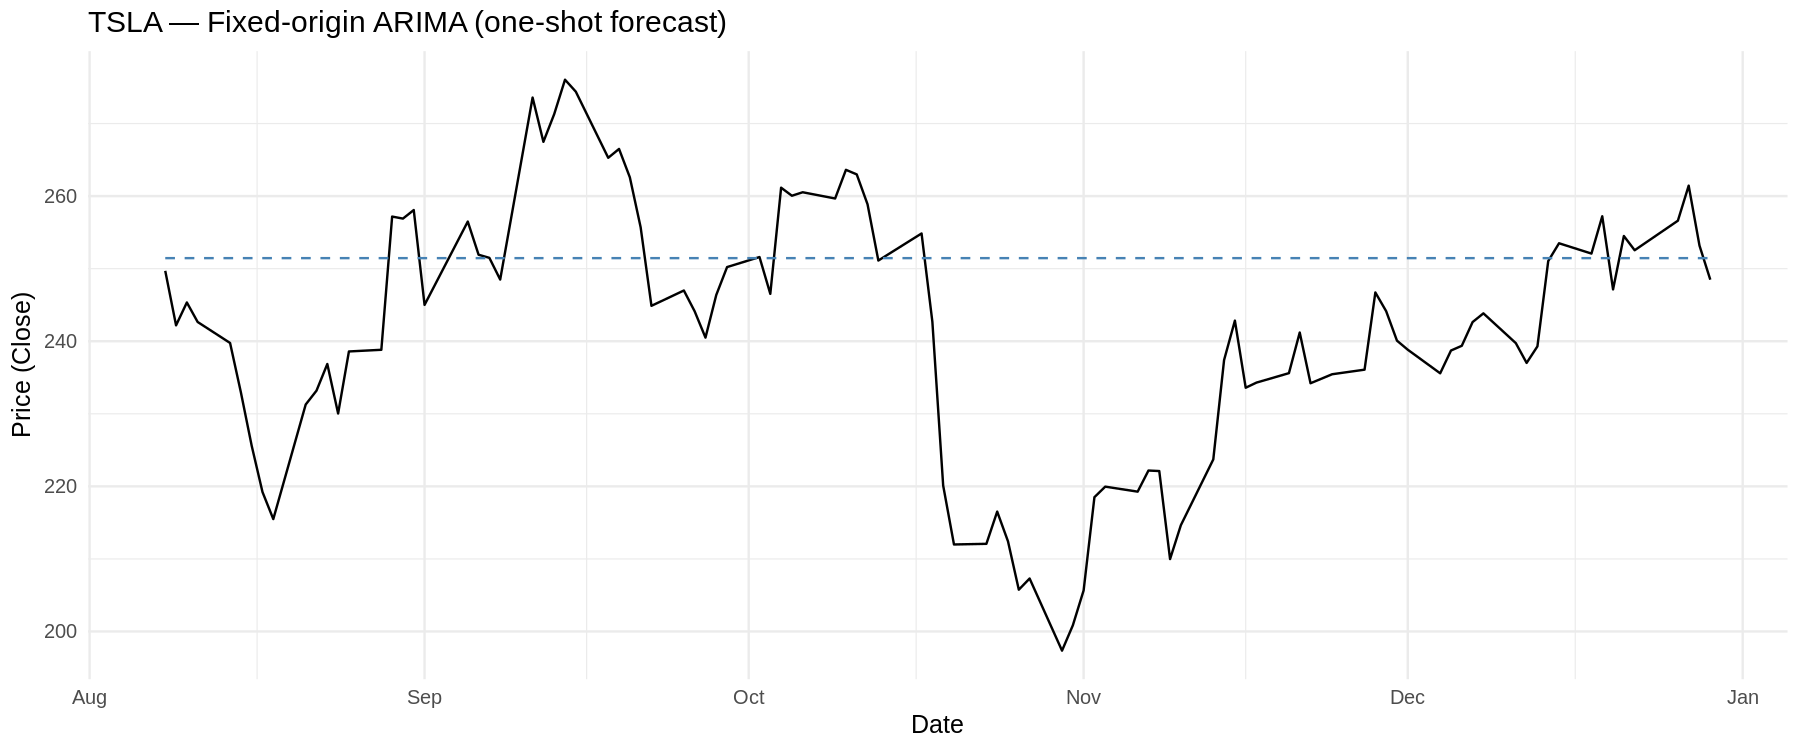

In [21]:
fit_fixed <- fit_train  # 이미 학습구간에서 선택된 모델 사용
f_fixed <- forecast(fit_fixed, h = length(y_test))

pred_fixed <- as.numeric(f_fixed$mean)

# 지표
rmse_fixed <- rmse(y_test, pred_fixed)
mae_fixed  <- mae(y_test, pred_fixed)
r2_fixed   <- r2(y_test, pred_fixed)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R^2=%.4f\n", rmse_fixed, mae_fixed, r2_fixed))

# 플롯
df_fx <- tibble(Date = dates_test, Actual = as.numeric(y_test), Pred = pred_fixed)
ggplot(df_fx, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "steelblue", linetype = "dashed") +
  labs(title = sprintf("%s — Fixed-origin ARIMA (one-shot forecast)", symbol),
       x = "Date", y = "Price (Close)")

### C. Rolling-origin + Rolling window
원점을 한 스텝씩 이동시키며, **고정 길이 W** 창으로 매번 `auto.arima` 재적합 후 **1-step ahead** 예측을 이어 붙입니다.

[Rolling window] RMSE=7.2057 | MAE=5.3890 | R^2=0.8290


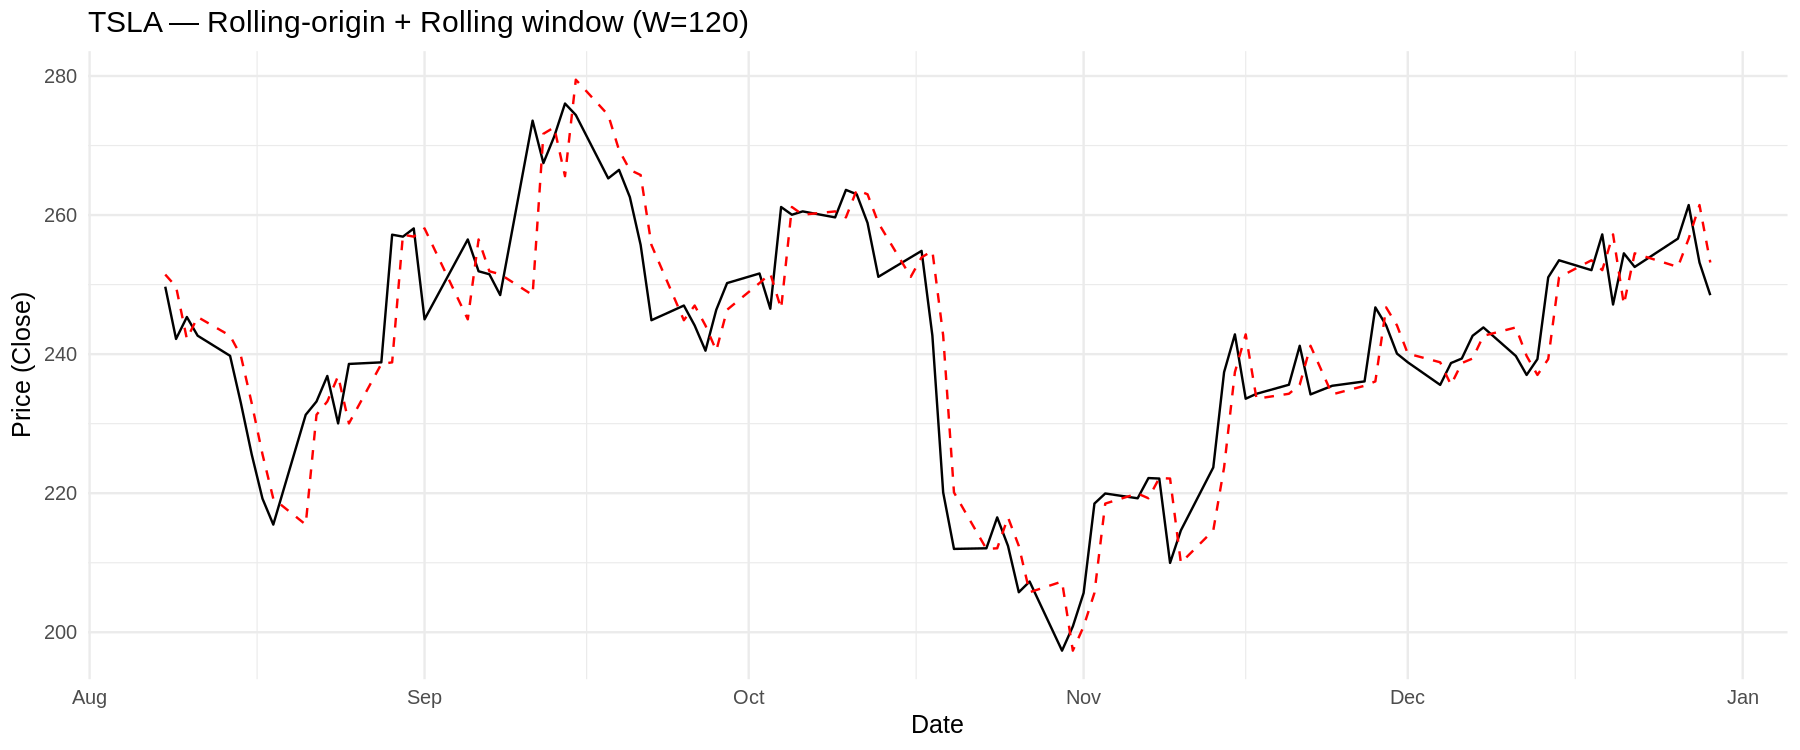

In [22]:
W <- 120   # 고정 창 길이 (필요시 조정)

hist <- as.numeric(y_train)
pred_roll <- rep(NA_real_, length(y_test))

for (i in seq_along(y_test)) {
  y_win <- if (length(hist) >= W) tail(hist, W) else hist
  # 1-step ahead
  pred_roll[i] <- one_step_forecast(y_win, d_limit = 1)
  # 워크-포워드: 실제값 편입
  hist <- c(hist, as.numeric(y_test[i]))
}

rmse_roll <- rmse(y_test, pred_roll)
mae_roll  <- mae(y_test, pred_roll)
r2_roll   <- r2(y_test, pred_roll)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R^2=%.4f\n", rmse_roll, mae_roll, r2_roll))

df_roll <- tibble(Date = dates_test, Actual = as.numeric(y_test), Pred = pred_roll)
ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "red", linetype = "dashed") +
  labs(title = sprintf("%s — Rolling-origin + Rolling window (W=%d)", symbol, W),
       x = "Date", y = "Price (Close)")

### D. Rolling-origin + Expanding window (Recursive)
원점은 이동하지만, **누적 창(처음부터 t까지)**으로 매 스텝 재적합하여 **1-step ahead** 예측을 이어 붙입니다.

[Expanding window] RMSE=7.1104 | MAE=5.2946 | R^2=0.8335


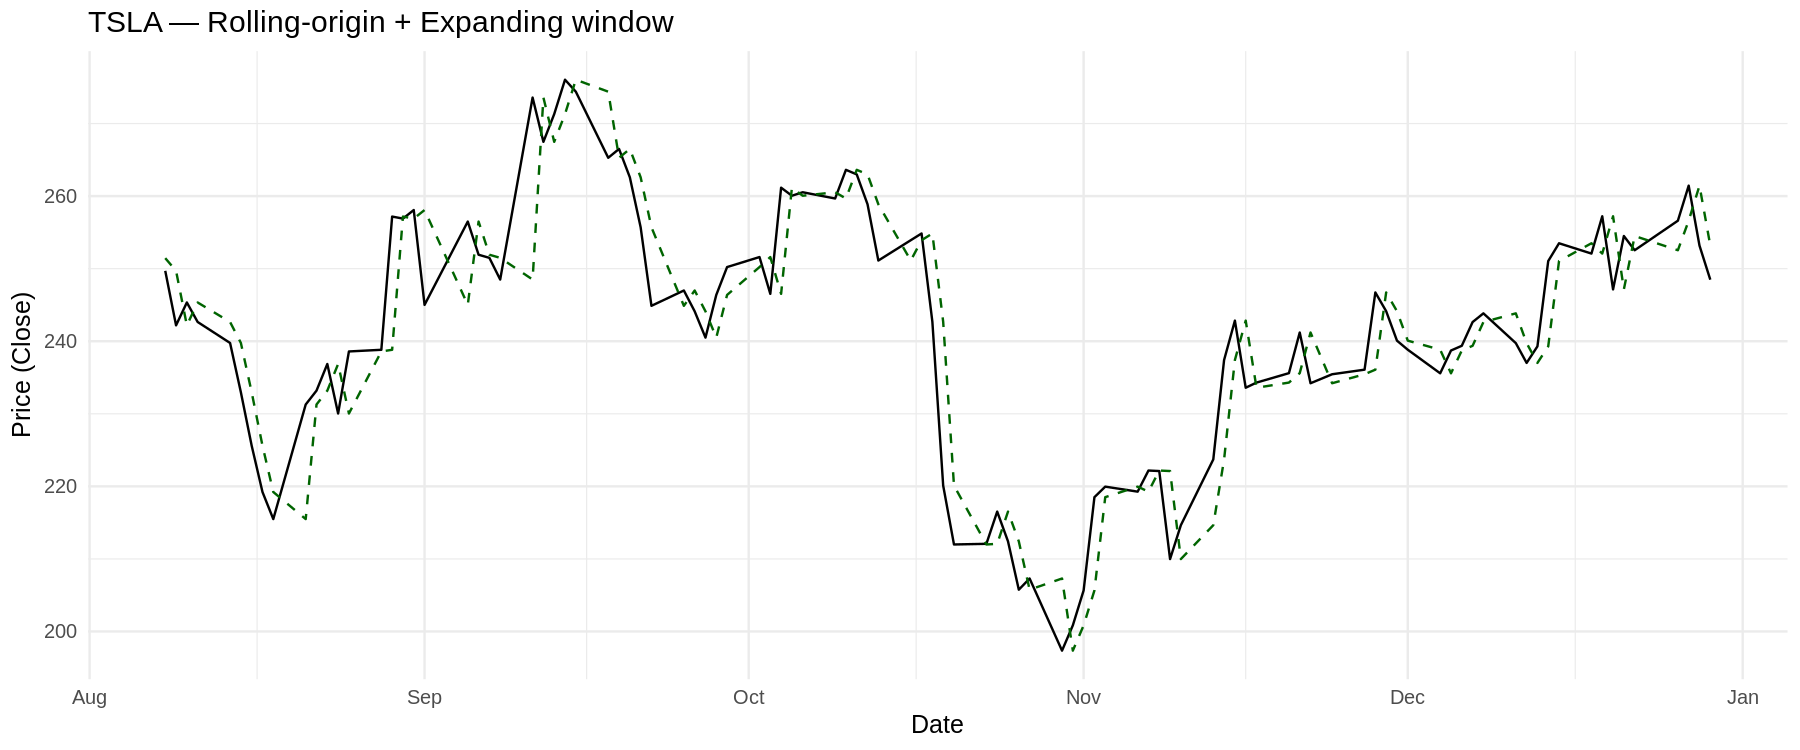

In [23]:
hist <- as.numeric(y_train)
pred_exp <- rep(NA_real_, length(y_test))

for (i in seq_along(y_test)) {
  # 누적창 전체로 1-step
  pred_exp[i] <- one_step_forecast(hist, d_limit = 1)
  hist <- c(hist, as.numeric(y_test[i]))
}

rmse_exp <- rmse(y_test, pred_exp)
mae_exp  <- mae(y_test, pred_exp)
r2_exp   <- r2(y_test, pred_exp)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R^2=%.4f\n", rmse_exp, mae_exp, r2_exp))

df_exp <- tibble(Date = dates_test, Actual = as.numeric(y_test), Pred = pred_exp)
ggplot(df_exp, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "darkgreen", linetype = "dashed") +
  labs(title = sprintf("%s — Rolling-origin + Expanding window", symbol),
       x = "Date", y = "Price (Close)")

# A tibble: 3 × 4
  Method                  RMSE   MAE     R2
  <chr>                  <dbl> <dbl>  <dbl>
1 Expanding window        7.11  5.29  0.833
2 Rolling window (W=120)  7.21  5.39  0.829
3 Fixed-origin (static)  20.0  15.3  -0.317


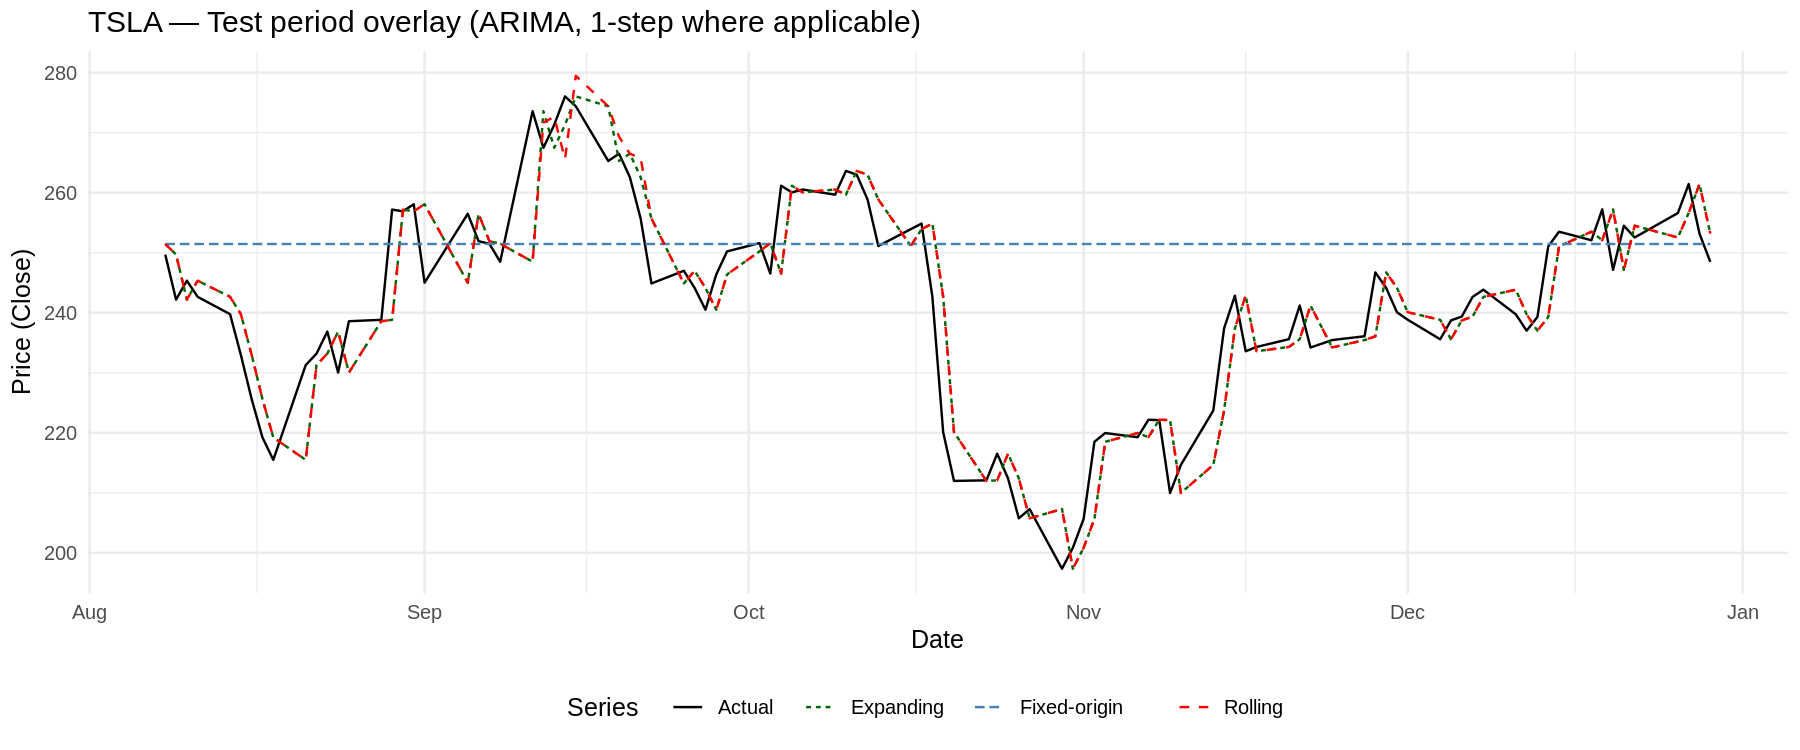

In [24]:
# -----------------------------
# 요약 지표 & 오버레이
# -----------------------------
summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin (static)",
             sprintf("Rolling window (W=%d)", W),
             "Expanding window"),
  RMSE = c(rmse_fixed, rmse_roll, rmse_exp),
  MAE  = c(mae_fixed,  mae_roll,  mae_exp),
  R2   = c(r2_fixed,   r2_roll,   r2_exp)
) %>% arrange(RMSE)

print(summary_tbl)

# 오버레이 플롯
overlay_df <- tibble(
  Date   = rep(dates_test, 4),
  Series = c(rep("Actual", length(y_test)),
             rep("Fixed-origin", length(y_test)),
             rep("Rolling", length(y_test)),
             rep("Expanding", length(y_test))),
  Value  = c(as.numeric(y_test), pred_fixed, pred_roll, pred_exp)
)

ggplot(overlay_df, aes(Date, Value, color = Series, linetype = Series)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black",
                                "Fixed-origin" = "steelblue",
                                "Rolling" = "red",
                                "Expanding" = "darkgreen")) +
  labs(title = sprintf("%s — Test period overlay (ARIMA, 1-step where applicable)", symbol),
       x = "Date", y = "Price (Close)") +
  theme(legend.position = "bottom")

In [25]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.4.0    tibble_3.3.0    dplyr_1.1.4     ggplot2_4.0.0  
 [5] quantmod_0.4.28 TTR_0.24.4      xts_0.14.1      zoo_1.8-14     
 [9] tseries_0.10-58 forecast_8.24.0

loa